In [28]:
import pandas as pd
import geopandas as gpd
import glob
import rasterio
import sys
sys.path.append('/projects/Developer/icesat2_boreal/lib')
import ExtractUtils

In [10]:
def get_raster_zonalstats(ZONAL_STATS_DICT, STATS_LIST = ['max','mean', 'median','std','min','sum','count'], DEBUG=False, AREA_HA_PER_PIXEL = 0.09):
    '''For each feature in the in_gdf, append cols from STATS_LIST based on the raster summary stats for the same region in vrt_fn
    ZONAL_STATS_DICT:
     {
            'ZONE_NAME': 'boreal_tiles_v003',
            'ZONE_FN': '/projects/shared-buckets/nathanmthomas/boreal_tiles_v003.gpkg',
            'REGION_NAME': 'above',
            'REGION_FN': '/projects/shared-buckets/lduncanson/data/above/ABoVE_Study_Domain.shp', # or a geodataframe
            'REGION_SEARCH_COL':'Region',
            'REGION_SEARCH_STR':'Region', #None
            'RASTER_DATASET_ID': 'biomass_prelim',
            'RASTER_FN': vrt_fn
    },
    '''
    
    import rasterstats
    import geopandas as gpd
    import pandas as pd
    import rasterio
    
    # Get the raster crs
    with rasterio.open(ZONAL_STATS_DICT['RASTER_FN'], mode='r') as src:
        raster_crs = src.crs

     # Reproject the zones and the regions to the raster crs
    in_gdf = gpd.read_file(ZONAL_STATS_DICT['ZONE_FN']).to_crs(raster_crs)
    
    if isinstance(ZONAL_STATS_DICT['REGION_FN'], gpd.GeoDataFrame):
        region_gdf = ZONAL_STATS_DICT['REGION_FN'].to_crs(raster_crs)
    else:
        region_gdf = gpd.read_file(ZONAL_STATS_DICT['REGION_FN']).to_crs(raster_crs)
        
    if DEBUG:
        # Plot of zones with regions in the raster crs
        ax = in_gdf.plot()
        region_gdf.boundary.plot(linewidth=1, color='black', ax=ax)

    if 'LAKE' in in_gdf.columns.to_list():
        # Remove lakes
        in_gdf = in_gdf[in_gdf.LAKE == 0]

    if ZONAL_STATS_DICT['REGION_SEARCH_STR'] is not None:
        # Select the zones based on the region string
        region_gdf_subset = region_gdf[region_gdf[ ZONAL_STATS_DICT['REGION_SEARCH_COL'] ].str.contains(ZONAL_STATS_DICT['REGION_SEARCH_STR']) ]
    else:
        region_gdf_subset = region_gdf
        
    region_gdf_subset['dissolve_field'] = 'for intersect'

    # Do a dissolve so that there is only 1 polygon to intersect; .iloc[0]
    selector = in_gdf.intersects(region_gdf_subset.dissolve(by='dissolve_field').iloc[0].geometry)

    in_gdf_subset = in_gdf[selector]
        
    print(f"# of {ZONAL_STATS_DICT['ZONE_NAME']} zones in {ZONAL_STATS_DICT['REGION_NAME']} for zonal stats:\t{len(in_gdf_subset)}")

    # If units of in_gdf are meters
    in_gdf_subset['area_sq_km'] = in_gdf_subset.area / 1e6

    # Reproject the zones and the regions to the raster crs
    in_gdf_subset_r_prj = in_gdf_subset.to_crs(raster_crs)
    
    if DEBUG:
        region_gdf_subset_r_prj = region_gdf_subset.to_crs(raster_crs)
        # Plot the zones across the region in the crs of the raster
        ax = in_gdf_subset_r_prj.plot()
        region_gdf_subset_r_prj.boundary.plot(ax=ax, linewidth=1, color='black')
        #in_gdf_subset_r_prj.head().plot(ax=ax, linewidth=1, color='red')
    
    nowtime = pd.Timestamp.now().strftime('%Y%m%d%H%M')
    print(f"Current time:\t{nowtime}")
    out_csv_fn = f"/projects/my-public-bucket/analyze_agb/zonal.{ZONAL_STATS_DICT['RASTER_DATASET_ID']}.{ZONAL_STATS_DICT['ZONE_NAME']}.{ZONAL_STATS_DICT['REGION_NAME']}.{nowtime}.geojson"

    print(f"Doing zonal stats:\nVRT:\t\t{ZONAL_STATS_DICT['RASTER_FN']}\nZONE TYPE:\t{ZONAL_STATS_DICT['ZONE_NAME']}\nREGION:\t\t{ZONAL_STATS_DICT['REGION_NAME']}\nSaving to:\t{out_csv_fn}")
   
    # Join zonal stats output back to original geodataframe
    out_gdf = in_gdf_subset_r_prj.reset_index(drop=True).join(
                                                pd.DataFrame(
                                                    rasterstats.zonal_stats(
                                                        vectors=in_gdf_subset_r_prj['geometry'], 
                                                        raster=ZONAL_STATS_DICT['RASTER_FN'], 
                                                        stats=STATS_LIST
                                                    )
                                                )
                                            )
    # Get the total tile AGB in Mg
    out_gdf['total_Mg'] =  out_gdf['sum']  / ( out_gdf['count'] * AREA_HA_PER_PIXEL)  # Mg_ha_sum / num_pixels * area_ha per pixel

    out_gdf.to_file(out_csv_fn, driver='GeoJSON')
    
    if DEBUG:
        ax = out_gdf.plot('median', cmap='viridis', legend=True, vmin=0, vmax=250, ax=ax)
        print(ax)
        
    return out_gdf

In [4]:
vrt_fn = '/projects/my-public-bucket/analyze_agb/AGB_tindex_america.vrt'

ZONAL_STATS_DICT = {'ZONE_NAME':'','ZONE_FN':'','REGION_NAME':'','REGION_FN':'','RASTER_NAME':'','RASTER_FN':''}
ZONAL_STATS_DICT_LIST = [
    {
            'ZONE_NAME': 'boreal_tiles_v003',
            'ZONE_FN': '/projects/shared-buckets/nathanmthomas/boreal_tiles_v003.gpkg',
            'REGION_NAME': 'above',
            'REGION_FN': '/projects/shared-buckets/lduncanson/data/above/ABoVE_Study_Domain.shp',
            'REGION_SEARCH_COL':'Region',
            'REGION_SEARCH_STR':'Region',
            'RASTER_DATASET_ID': 'biomass_prelim',
            'RASTER_FN': vrt_fn
    },
    {
            'ZONE_NAME': 'boreal_tiles_v003',
            'ZONE_FN': '/projects/shared-buckets/nathanmthomas/boreal_tiles_v003.gpkg',
            'REGION_NAME': 'boreal_na',
            'REGION_FN': '/projects/my-public-bucket/analyze_agb/input_zones/wwf_circumboreal_Dissolve.geojson',
            'REGION_SEARCH_COL':'REALM',
            'REGION_SEARCH_STR':'NA',
            'RASTER_DATASET_ID': 'biomass_prelim',
            'RASTER_FN': vrt_fn
    },
    {
            'ZONE_NAME': 'hybas_lev06',
            'ZONE_FN': '/projects/my-public-bucket/analyze_agb/input_zones/hybas_lake_GLOBAL_lev06_v1c.shp',
            'REGION_NAME': 'above',
            'REGION_FN': '/projects/shared-buckets/lduncanson/data/above/ABoVE_Study_Domain.shp',
            'REGION_SEARCH_COL':'Region',
            'REGION_SEARCH_STR':'Region',
            'RASTER_DATASET_ID': 'biomass_prelim',
            'RASTER_FN': vrt_fn
    },
    {
            'ZONE_NAME': 'hybas_lev06',
            'ZONE_FN': '/projects/my-public-bucket/analyze_agb/input_zones/hybas_lake_GLOBAL_lev06_v1c.shp',
            'REGION_NAME': 'above',
            'REGION_FN': '/projects/my-public-bucket/analyze_agb/input_zones/hybas_lake_GLOBAL_lev03_v1c.shp',
            'REGION_SEARCH_COL':'Region',
            'REGION_SEARCH_STR':'Region',
            'RASTER_DATASET_ID': 'biomass_prelim',
            'RASTER_FN': vrt_fn
    },
]


In [5]:
ZONAL_STATS_DICT = ZONAL_STATS_DICT_LIST[3]
ZONAL_STATS_DICT

{'ZONE_NAME': 'hybas_lev06',
 'ZONE_FN': '/projects/my-public-bucket/analyze_agb/input_zones/hybas_lake_GLOBAL_lev06_v1c.shp',
 'REGION_NAME': 'above',
 'REGION_FN': '/projects/my-public-bucket/analyze_agb/input_zones/hybas_lake_GLOBAL_lev03_v1c.shp',
 'REGION_SEARCH_COL': 'Region',
 'REGION_SEARCH_STR': 'Region',
 'RASTER_DATASET_ID': 'biomass_prelim',
 'RASTER_FN': '/projects/my-public-bucket/analyze_agb/AGB_tindex_america.vrt'}

### Select regions of interest with a general box; make a list of individual region geodataframes

In [6]:
vector_gdf = gpd.read_file(ZONAL_STATS_DICT['REGION_FN']).cx[-180:-45,45:90]
vector_gdf.info()

geoms_list = []
zone_name_list = []
poly_list = []
gdf_list = []
zone_field_name = 'HYBAS_ID'

for idx in vector_gdf.index:
    #print(idx)
    geom =  vector_gdf.loc[idx].geometry
    zonename =  vector_gdf.loc[idx][zone_field_name]
    
    if geom not in geoms_list:
        #gpd.GeoSeries(geom).plot()
        geoms_list.append(geom)
        zone_name_list.append(zonename)
        poly_list.append(gpd.GeoSeries(geom))
        gdf_list.append(gpd.GeoDataFrame(geometry=gpd.GeoSeries(geom), crs=vector_gdf.crs))

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 33 entries, 99 to 143
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   HYBAS_ID   33 non-null     int64   
 1   NEXT_DOWN  33 non-null     int64   
 2   NEXT_SINK  33 non-null     int64   
 3   MAIN_BAS   33 non-null     int64   
 4   DIST_SINK  33 non-null     float64 
 5   DIST_MAIN  33 non-null     float64 
 6   geometry   33 non-null     geometry
dtypes: float64(2), geometry(1), int64(4)
memory usage: 2.1 KB


In [7]:
zone_name_list[20]

8030010700

## Update the dictionary with region of interest

{'ZONE_NAME': 'hybas_lev06',
 'ZONE_FN': '/projects/my-public-bucket/analyze_agb/input_zones/hybas_lake_GLOBAL_lev06_v1c.shp',
 'REGION_NAME': 'HYBAS_L03_7030021430',
 'REGION_FN':                                             geometry
 0  MULTIPOLYGON (((-93.57639 58.78333, -93.58536 ...,
 'REGION_SEARCH_COL': 'Region',
 'REGION_SEARCH_STR': None,
 'RASTER_DATASET_ID': 'biomass_prelim',
 'RASTER_FN': '/projects/my-public-bucket/analyze_agb/AGB_tindex_america.vrt'}

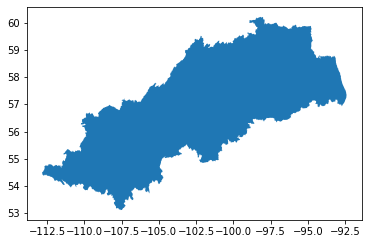

In [8]:
# Example for a single region
IDX=3
gdf_list[IDX].plot()

ZONAL_STATS_DICT.update({'REGION_FN': gdf_list[IDX], 'REGION_SEARCH_STR': None, 'REGION_NAME': f"HYBAS_L03_{zone_name_list[IDX]}" })
ZONAL_STATS_DICT

## Loop over regions of interest, returning zonal stats for all zones in region

# of hybas_lev06 zones in HYBAS_L03_8030005520 for zonal stats:	75
Current time:	202204221137
Doing zonal stats:
VRT:		/projects/my-public-bucket/analyze_agb/AGB_tindex_america.vrt
ZONE TYPE:	hybas_lev06
REGION:		HYBAS_L03_8030005520
Saving to:	/projects/my-public-bucket/analyze_agb/zonal.biomass_prelim.hybas_lev06.HYBAS_L03_8030005520.202204221137.geojson


/opt/conda/lib/python3.7/site-packages/geopandas/geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


AxesSubplot(0.365634,0.125;0.379366x0.755)
# of hybas_lev06 zones in HYBAS_L03_8030008900 for zonal stats:	17
Current time:	202204221154
Doing zonal stats:
VRT:		/projects/my-public-bucket/analyze_agb/AGB_tindex_america.vrt
ZONE TYPE:	hybas_lev06
REGION:		HYBAS_L03_8030008900
Saving to:	/projects/my-public-bucket/analyze_agb/zonal.biomass_prelim.hybas_lev06.HYBAS_L03_8030008900.202204221154.geojson


/opt/conda/lib/python3.7/site-packages/geopandas/geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


AxesSubplot(0.248498,0.125;0.496502x0.755)
# of hybas_lev06 zones in HYBAS_L03_8030009560 for zonal stats:	325
Current time:	202204221159
Doing zonal stats:
VRT:		/projects/my-public-bucket/analyze_agb/AGB_tindex_america.vrt
ZONE TYPE:	hybas_lev06
REGION:		HYBAS_L03_8030009560
Saving to:	/projects/my-public-bucket/analyze_agb/zonal.biomass_prelim.hybas_lev06.HYBAS_L03_8030009560.202204221159.geojson


/opt/conda/lib/python3.7/site-packages/geopandas/geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


AxesSubplot(0.125,0.164979;0.62x0.675042)
# of hybas_lev06 zones in HYBAS_L03_8030009570 for zonal stats:	38
Current time:	202204221343
Doing zonal stats:
VRT:		/projects/my-public-bucket/analyze_agb/AGB_tindex_america.vrt
ZONE TYPE:	hybas_lev06
REGION:		HYBAS_L03_8030009570
Saving to:	/projects/my-public-bucket/analyze_agb/zonal.biomass_prelim.hybas_lev06.HYBAS_L03_8030009570.202204221343.geojson


/opt/conda/lib/python3.7/site-packages/geopandas/geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


AxesSubplot(0.181129,0.125;0.563871x0.755)
# of hybas_lev06 zones in HYBAS_L03_8030010700 for zonal stats:	116
Current time:	202204221353
Doing zonal stats:
VRT:		/projects/my-public-bucket/analyze_agb/AGB_tindex_america.vrt
ZONE TYPE:	hybas_lev06
REGION:		HYBAS_L03_8030010700
Saving to:	/projects/my-public-bucket/analyze_agb/zonal.biomass_prelim.hybas_lev06.HYBAS_L03_8030010700.202204221353.geojson


/opt/conda/lib/python3.7/site-packages/geopandas/geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


AxesSubplot(0.231656,0.125;0.513344x0.755)
# of hybas_lev06 zones in HYBAS_L03_8030016860 for zonal stats:	112
Current time:	202204221407
Doing zonal stats:
VRT:		/projects/my-public-bucket/analyze_agb/AGB_tindex_america.vrt
ZONE TYPE:	hybas_lev06
REGION:		HYBAS_L03_8030016860
Saving to:	/projects/my-public-bucket/analyze_agb/zonal.biomass_prelim.hybas_lev06.HYBAS_L03_8030016860.202204221407.geojson


/opt/conda/lib/python3.7/site-packages/geopandas/geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


AxesSubplot(0.330879,0.125;0.414121x0.755)
# of hybas_lev06 zones in HYBAS_L03_8030020760 for zonal stats:	8
Current time:	202204221432
Doing zonal stats:
VRT:		/projects/my-public-bucket/analyze_agb/AGB_tindex_america.vrt
ZONE TYPE:	hybas_lev06
REGION:		HYBAS_L03_8030020760
Saving to:	/projects/my-public-bucket/analyze_agb/zonal.biomass_prelim.hybas_lev06.HYBAS_L03_8030020760.202204221432.geojson


/opt/conda/lib/python3.7/site-packages/geopandas/geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


AxesSubplot(0.295784,0.125;0.449216x0.755)
# of hybas_lev06 zones in HYBAS_L03_8030022890 for zonal stats:	9
Current time:	202204221432
Doing zonal stats:
VRT:		/projects/my-public-bucket/analyze_agb/AGB_tindex_america.vrt
ZONE TYPE:	hybas_lev06
REGION:		HYBAS_L03_8030022890
Saving to:	/projects/my-public-bucket/analyze_agb/zonal.biomass_prelim.hybas_lev06.HYBAS_L03_8030022890.202204221432.geojson


/opt/conda/lib/python3.7/site-packages/geopandas/geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


IndexError: index 0 is out of bounds for axis 0 with size 0

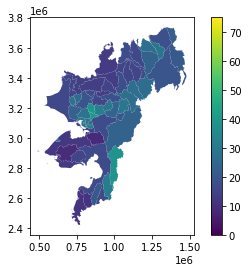

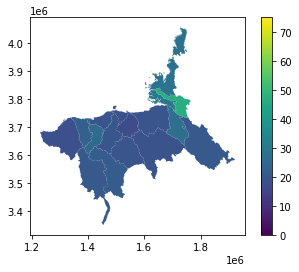

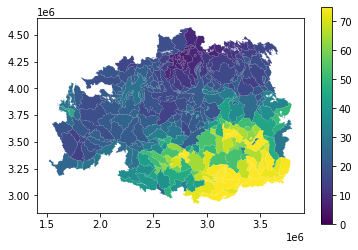

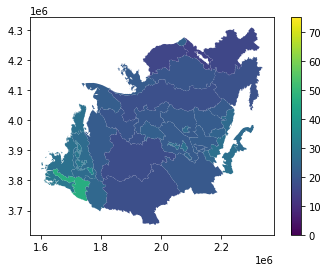

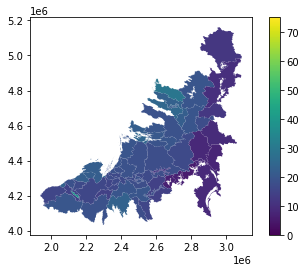

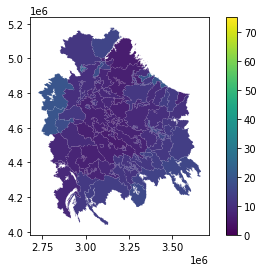

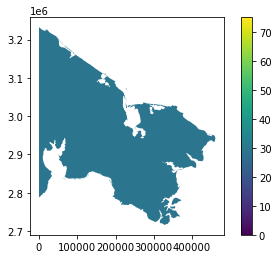

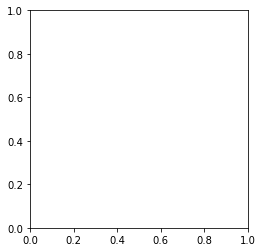

In [11]:
%%time
for i in range(16, len(gdf_list)):
    ZONAL_STATS_DICT.update({'REGION_FN': gdf_list[i], 'REGION_SEARCH_STR': None, 'REGION_NAME': f"HYBAS_L03_{zone_name_list[i]}" })
    z = get_raster_zonalstats(ZONAL_STATS_DICT, DEBUG=False)
    ax = z.plot('median', cmap='viridis', legend=True, vmin=0, vmax=75)
    print(ax)

IndexError: index 0 is out of bounds for axis 0 with size 0

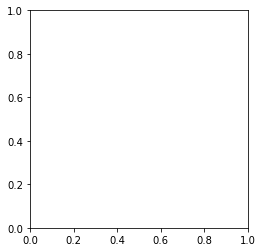

In [12]:
#z['total_Mg'] =  z['sum']  / ( z['count'] * 0.09)  # Mg_ha_sum / num_pixels * area_ha per pixel
#z.to_file('/projects/my-public-bucket/analyze_agb/zonal.biomass_prelim.hybas_lev06.HYBAS_L03_8030005510.202204220130.geojson', driver='GeoJSON')
ax = z.plot('median', cmap='viridis', legend=True, vmin=0, vmax=75)
print(ax)

In [96]:
files = glob.glob('/projects/my-public-bucket/analyze_agb/zonal.biomass_prelim.hybas_lev06.HYBAS_L03*.geojson')
zonal_lev06 = pd.concat([gpd.read_file(f) for f in files])
zonal_lev06.shape

(2755, 17)

In [98]:
above_domain_fn = '/projects/shared-buckets/lduncanson/data/above/ABoVE_Study_Domain.shp'
above_domain_gdf = gpd.read_file(above_domain_fn)#.cx[-180:-150, 50:75]
with rasterio.open(ZONAL_STATS_DICT['RASTER_FN'], mode='r') as src:
    raster_crs = src.crs
zonal_lev06.set_crs(raster_crs, allow_override=True, inplace=True)
zonal_lev06.crs

DriverError: /projects/shared-buckets/lduncanson/data/above/ABoVE_Study_Domain.shp: Transport endpoint is not connected

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  """


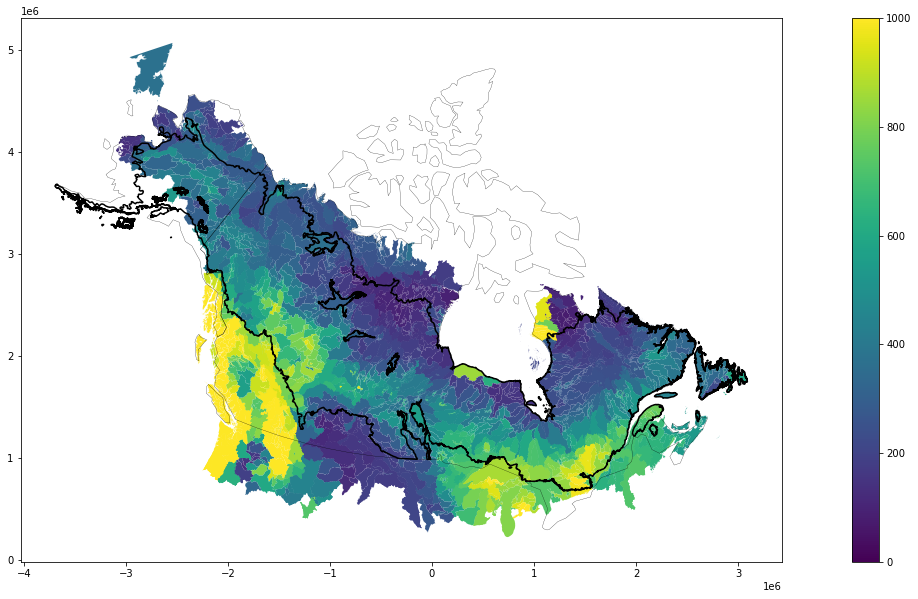

In [71]:
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [25, 10]

world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres") )
alaska = world[world.name == 'United States of America'].explode().cx[-170:-50, 50:90]
canada = world[world.name == 'Canada']
canada_alaska = pd.concat([alaska, canada])
boreal_gdf = gpd.read_file('/projects/my-public-bucket/analyze_agb/input_zones/wwf_circumboreal_Dissolve.geojson')

ax = canada_alaska.cx[-170:-50,50:90].to_crs(above_domain_gdf.crs).boundary.plot(color='black', linewidth=0.25)
ax = boreal_gdf.cx[-180:-50,50:90].to_crs(above_domain_gdf.crs).boundary.plot(color='black', ax=ax)
zonal_lev06.to_crs(above_domain_gdf.crs).plot('total_Mg', cmap='viridis', legend=True, vmin=0, vmax=1000, ax=ax)


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f287d859690>]],
      dtype=object)

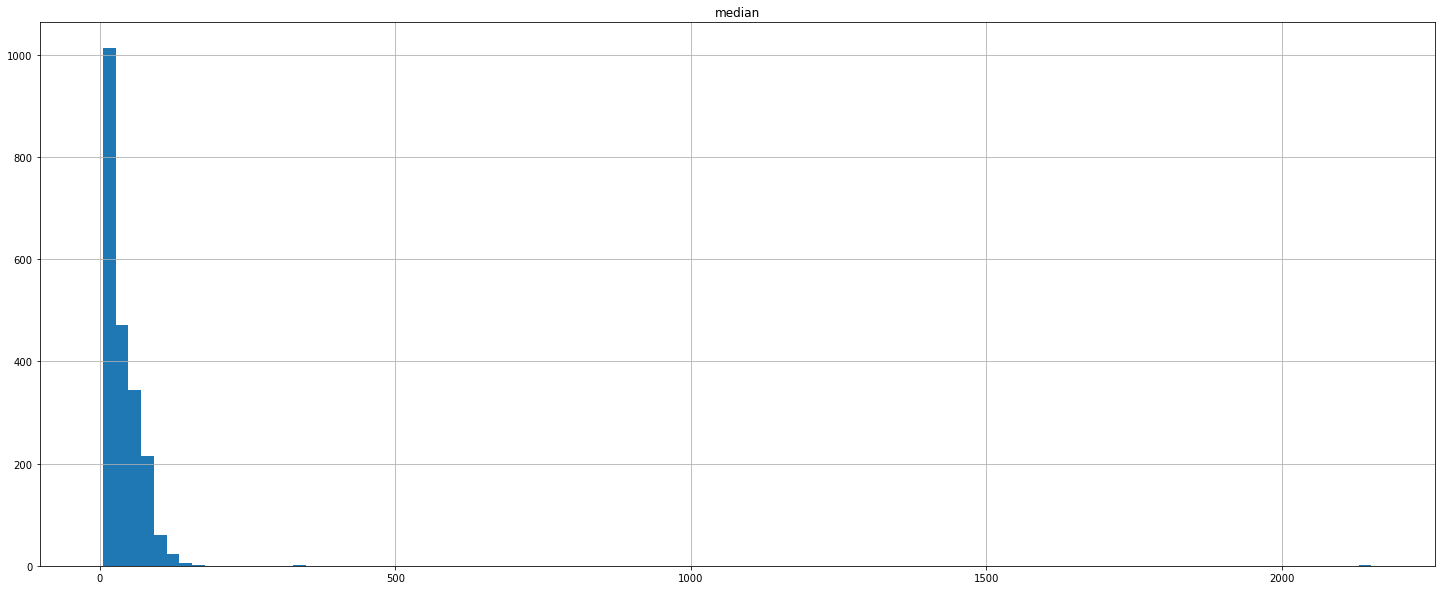

In [74]:
z.hist('median', bins=100)

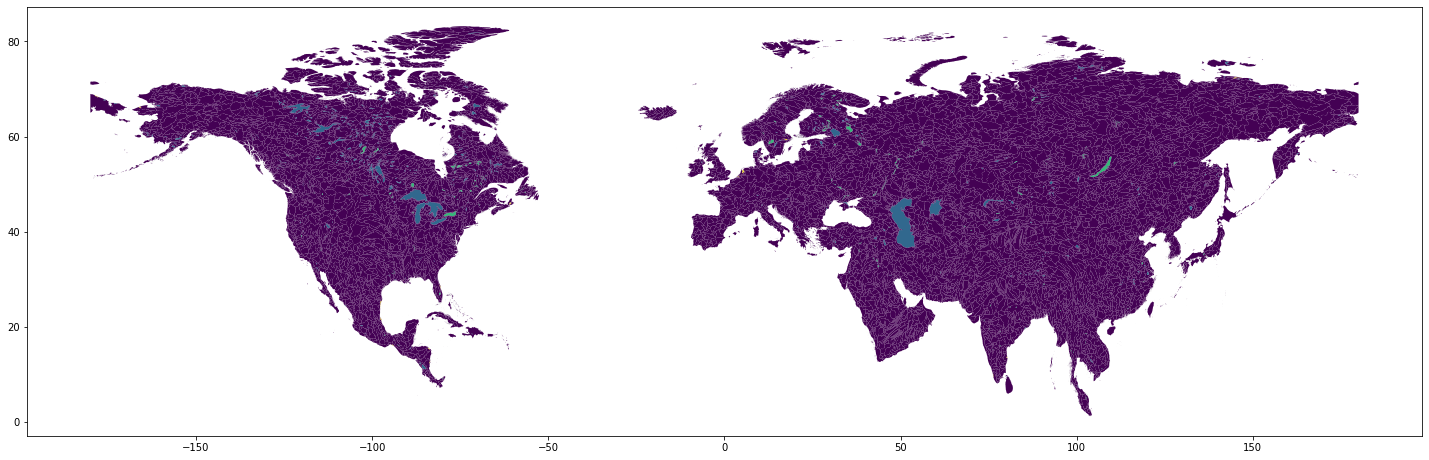

In [95]:
hybas_lev06 = pd.concat([gpd.read_file(f) for f in glob.glob('/projects/my-public-bucket/analyze_agb/hydrobasins/hybas_lake_*_lev06_v1c.shp')])
hybas_lev06.plot(column='LAKE')

In [88]:
import zipfile
zipdir = '/projects/my-public-bucket/analyze_agb/hydrobasins'
files = glob.glob(f'{zipdir}/*_as_*.zip')
for f in files:
    with zipfile.ZipFile(f, 'r') as zip_ref:
        zip_ref.extractall(zipdir)